In [27]:
import math
import numpy as np
import pandas as pd
import scipy
import  scipy.signal as sg


import requests
import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import mplfinance as mpf



In [16]:

def fetch_historical_data(base_curr, quote_curr, start_time, end_time, granularity=86400):
    """
    Fetches all available historical OHLCV data from Coinbase API.
    
    Args:
    - base_curr (str): Cryptocurrency base (e.g., "BTC", "ETH").
    - quote_curr (str): Cryptocurrency base (e.g., "USDT").
    - start_time (str): Start date in "YYYY-MM-DD" format.
    - end_time (str): End date in "YYYY-MM-DD" format.
    - granularity (int): Timeframe in seconds (default: 86400 for daily data).
    
    Returns:
    - pd.DataFrame: Dataframe containing all historical OHLCV data.
    """

    # Convert symbol format (BTCUSDT -> BTC-USD)
    pair = f"{base_curr}-{quote_curr}"

    url = f"https://api.exchange.coinbase.com/products/{pair}/candles"
    
    # Convert start_time and end_time to datetime objects
    start_dt = datetime.strptime(start_time, "%Y-%m-%d")
    end_dt = datetime.strptime(end_time, "%Y-%m-%d")

    all_data = []
    
    while start_dt < end_dt:
        batch_end = min(end_dt, start_dt + timedelta(seconds=granularity * 300))
        
        params = {
            "granularity": granularity,
            "start": start_dt.strftime("%Y-%m-%dT%H:%M:%SZ"),
            "end": batch_end.strftime("%Y-%m-%dT%H:%M:%SZ")
        }

        response = requests.get(url, params=params)
        
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break

        data = response.json()
        
        if not data:
            print("No data found for this period.")
            break
        
        all_data.extend(data)
        start_dt = batch_end + timedelta(seconds=granularity)

    if not all_data:
        print("No historical data available.")
        return None

    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=["timestamp", "low", "high", "open", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    df = df.sort_values("timestamp").reset_index(drop=True)

    return df

# Example Usage
df = fetch_historical_data("btc", "usdt", "2024-01-01", "2025-03-15")

In [17]:
df

,timestamp,low,high,open,close,volume
0,2024-01-01,42178.40,44195.57,42293.69,44176.97,729.393558
1,2024-01-02,44157.45,45880.95,44183.08,44954.64,1767.612268
2,2024-01-03,40545.71,45507.46,44959.03,42841.60,2638.324645
3,2024-01-04,42619.10,44745.07,42841.76,44154.57,1386.935236
4,2024-01-05,42401.97,44368.38,44153.69,44128.22,1361.430971
...,...,...,...,...,...,...
435,2025-03-11,76568.32,83631.08,78654.26,82964.97,858.416433
436,2025-03-12,80598.32,84466.04,82973.79,83682.95,650.069883
437,2025-03-13,79924.93,84333.22,83695.27,81082.78,593.616611
438,2025-03-14,80818.41,85302.25,81097.84,83981.73,318.176259


## Indicators 

In [28]:

def sma(price, n):
  return price.rolling(n).mean()
def wma(price, n):
  return price.ewm(com=n).mean()

def highpass(Data, n=48):
  a	= (0.707*2*math.pi) / n

  alpha1 = (math.cos(a)+math.sin(a)-1)/math.cos(a);
  b	= 1-alpha1/2
  c	= 1-alpha1

  ret = [0] * len(Data)
  for i in range(2, len(Data)):
    ret[i] = b*b*(Data.iloc[i]-2*Data[i-1]+Data.iloc[i-2])+2*c*ret[i-1]-c*c*ret[i-2]

  return pd.Series(ret, index=Data.index)

def lowpass(Data,n):
  a = 2.0/(1+n)

  lp = [Data[0], Data[1]] + [0] * (len(Data) - 2)
  for i in range(2, len(Data)):
    lp[i] = (a-0.25*a*a)*Data[i]+ 0.5*a*a*Data[i-1]\
      - (a-0.75*a*a)*Data[i-2]\
      + 2*(1.-a)*lp[i-1]\
      - (1.-a)*(1.-a)*lp[i-2]

  return pd.Series(lp, index=Data.index)

def hullma(price, n):
  wma1 = wma(price, n//2)
  wma2 = wma(price, n)
  return wma(wma1 * 2 - wma2, int(math.sqrt(n)))

def zlma(price, n):
  """
  John Ehlers' Zero lag (exponential) moving average
  https://en.wikipedia.org/wiki/Zero_lag_exponential_moving_average
  """
  lag = (n - 1) // 2
  series = 2 * price - price.shift(lag)
  return wma(series, n)


def detrend(price, n):
  return price - highpass(price, n)


def alma(price, n):
  h = sg.windows.gaussian(n, n * 0.2)
  fil = sg.convolve(price, h / h.sum())
  filtered = pd.Series(fil[:len(price)], index=price.index)
  return filtered

### Simple Moving Averages Cross Over Signals

In [29]:
def generate_signals(df, short_window=20, long_window=60):
    df['SMA_20'] = sma(df['close'], short_window)
    df['SMA_60'] = sma(df['close'], long_window)

    df['Signal'] = np.where(df['SMA_20'] > df['SMA_60'], 1, -1)
    
    df['Crossover'] = df['Signal'].diff()

    return df

In [30]:
def backtest(df, initial_capital=10000):
    df = df.copy()
    df['Daily Returns'] = df['close'].pct_change()

    df['Strategy Returns'] = df['Signal'].shift(1) * df['Daily Returns']
    df['Cumulative Market'] = (1 + df['Daily Returns']).cumprod() * initial_capital
    df['Cumulative Strategy'] = (1 + df['Strategy Returns']).cumprod() * initial_capital

    return df

In [31]:
def plot_chart(df):
    df = df.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot SMA lines
    ax.plot(df.index, df['SMA_20'], label='SMA 20', color='blue', linestyle='--')
    ax.plot(df.index, df['SMA_60'], label='SMA 60', color='red', linestyle='--')

    # Mark buy (golden cross) & sell (death cross) signals
    buy_signals = df[df['Crossover'] == 2]  # Golden Cross
    sell_signals = df[df['Crossover'] == -2]  # Death Cross

    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal', alpha=1, edgecolor='black')
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal', alpha=1, edgecolor='black')

    ax.legend()
    ax.set_title("SMA Crossover Strategy")
    ax.set_ylabel("Price")
    plt.show()

    # Candlestick chart
    df_mpf = df[['open', 'high', 'low', 'close', 'volume']].copy()

    mpf.plot(df_mpf, type='candle', style='charles', 
             mav=(20, 60), volume=True, title="Candlestick with SMA", 
             figsize=(12, 6))
    

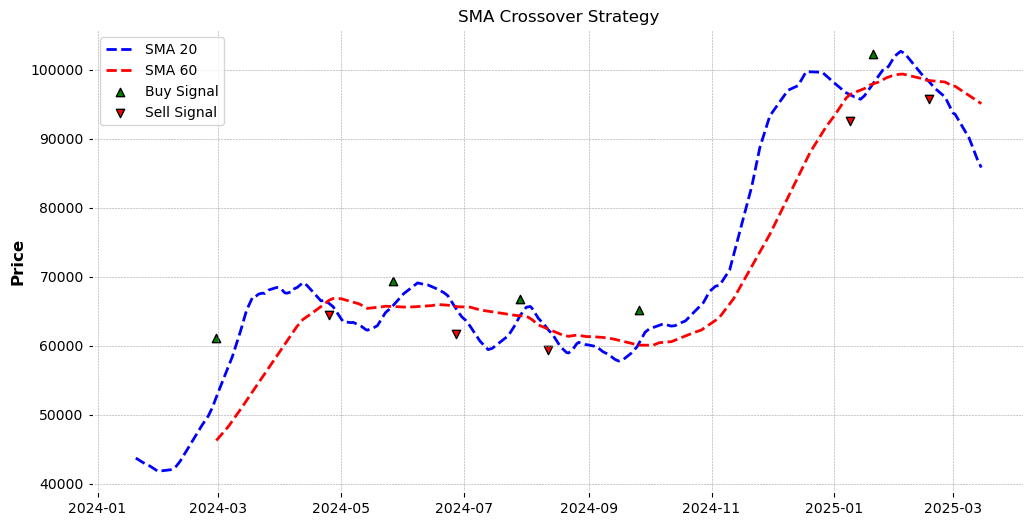

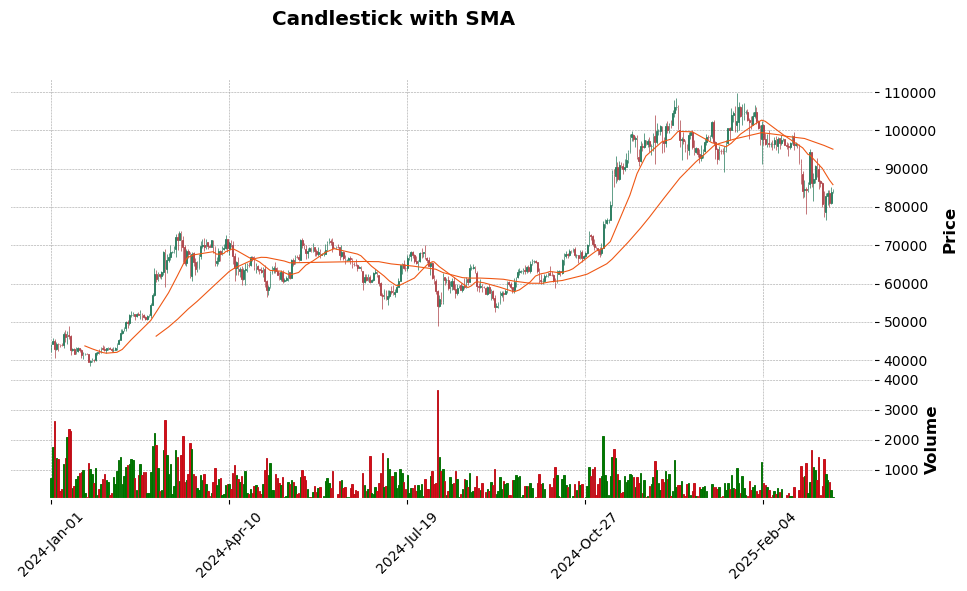

Final Portfolio Value: $5479.45


In [32]:
# Main Execution
df = generate_signals(df, 20, 60)
df = backtest(df)
plot_chart(df)

# Print final portfolio value
print(f"Final Portfolio Value: ${df['Cumulative Strategy'].iloc[-1]:.2f}")


### A more comprehensive strategy

In [ ]:
df['HMA'] = hullma(df['close'], 20)  
df['ZLMA'] = zlma(df['close'], 20)  
df['DPO'] = detrend(df['close'], 20)  

df['Signal'] = np.where((df['SMA_20'] > df['SMA_60']) & (df['ZLMA'] > df['DPO']), 1, 0)
df['Signal'] = np.where((df['SMA_20'] < df['SMA_60']) & (df['DPO'] < 0), -1, df['Signal'])

df['ATR'] = df['high'] - df['low']  
stop_loss = df['close'] - df['ATR'] * 1.5  # 1.5x ATR Stop Loss  
take_profit = df['close'] + df['ATR'] * 3  # 3x ATR Take Profit  

df['ALMA'] = alma(df['close'], 20)  
df['Highpass'] = highpass(df['close'], 48)  

df['Confirmed Buy'] = (df['Signal'] == 1) & (df['ALMA'] > df['Highpass'])  
df['Confirmed Sell'] = (df['Signal'] == -1) & (df['ALMA'] < df['Highpass'])

df['Position Size'] = np.maximum(100 / df['ATR'], 1)



In [38]:
df['ATR'] = df['high'] - df['low']  
stop_loss = df['close'] - df['ATR'] * 1.5  # 1.5x ATR Stop Loss  
take_profit = df['close'] + df['ATR'] * 3  # 3x ATR Take Profit  

In [35]:
df['ALMA'] = alma(df['close'], 20)  
df['Highpass'] = highpass(df['close'], 48)  

df['Confirmed Buy'] = (df['Signal'] == 1) & (df['ALMA'] > df['Highpass'])  
df['Confirmed Sell'] = (df['Signal'] == -1) & (df['ALMA'] < df['Highpass'])

In [36]:
df['Position Size'] = np.maximum(100 / df['ATR'], 1)